<a href="https://colab.research.google.com/github/ZoliN/colab/blob/main/MODNet_Inference_with_onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet - Inference with onnx

This notebook is the modified version of the main [colab demo](https://colab.research.google.com/drive/1GANpbKT06aEFiW-Ssx0DQnnEADcXwQG6?usp=sharing#scrollTo=JOmYOHKfgQ5Y). Refer it for more information. 


In this demo, we provide a very high performance **inference ready onnx model** for image matting. It also supports dynamic input and output shapes. <b><font color='#00FF0'>The inference time is also very less and you don't need **GPU** to run it. </font></b>

## 1. Preparation

Clone the repository and download the pretrained model.

In [ ]:
!pip install onnx onnxruntime
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/manthan3C273/MODNet
%cd MODNet/

# dowload the onnx model for image matting
model = 'modnet.onnx'
if not os.path.exists(model):
  !gdown --id 1cgycTQlYXpTh26gB9FTnthE7AvruV8hd \
          -O pretrained/modnet.onnx

## 2. Upload image

Upload portrait images to be processed (only PNG and JPG format are supported). 

Download demo image. Photo by Charlotte May from [Pexels](https://www.pexels.com/photo/unrecognizable-asian-woman-with-rucksack-in-town-5965592/)

In [ ]:
# dowload image
image = 'image.jpg'
if not os.path.exists(image):
  !gdown --id 1fkyh03NEuSwvjFttYVwV7TjnJML04Xn6 \
          -O image.jpg

## 3. Inference

Run the following command for alpha matte prediction.

In [29]:
%cd /content/MODNet
!python demo/image_matting/Inference_with_ONNX/inference_onnx.py \
        --image-path=image.jpg \
        --output-path=matte.png \
        --model-path=pretrained/modnet672_16.onnx

/content/MODNet
[ WARN:0@2.265] global onnx_graph_simplifier.cpp:804 getMatFromTensor DNN: load FP16 model as FP32 model, and it takes twice the FP16 RAM requirement.
[ERROR:0@2.278] global onnx_importer.cpp:1051 handleNode DNN/ONNX: ERROR during processing node with 3 inputs and 1 outputs: [Conv]:(onnx_node!Conv_0) from domain='ai.onnx'
Traceback (most recent call last):
  File "/content/MODNet/demo/image_matting/Inference_with_ONNX/inference_onnx.py", line 110, in <module>
    model = cv2.dnn.readNet(model=args.model_path)
cv2.error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1073: error: (-2:Unspecified error) in function 'handleNode'
> Node [Conv@ai.onnx]:(onnx_node!Conv_0) parse error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/layers/convolution_layer.cpp:398: error: (-215:Assertion failed) inputs.size() != 0 in function 'getMemoryShapes'
> 


In [ ]:
#!pip install onnxsim onnxruntime
!onnxsim /content/MODNet/pretrained/modnet16.onnx /content/MODNet/pretrained/modnet16_672.onnx --overwrite-input-shape 1,3,672,512


In [ ]:
#!pip install onnx-tf
!python -m onnxruntime.tools.convert_onnx_models_to_ort --target_platform arm --save_optimized_onnx_model /content/MODNet/pretrained/modnet.onnx 

In [24]:
#!pip install onnx onnxconverter-common
import onnx
from onnxconverter_common import float16

model = onnx.load("/content/MODNet/pretrained/modnet672.onnx")
model_fp16 = float16.convert_float_to_float16(model, keep_io_types=True, disable_shape_infer=True)
onnx.save(model_fp16, "/content/MODNet/pretrained/modnet672_16.onnx")

/usr/local/lib/python3.10/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -5.787889278963121e-08 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.10/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 7.678913505060336e-09 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(pos_min, min_positive_val))
/usr/local/lib/python3.10/dist-packages/onnxconverter_common/float16.py:53: UserWarning: the float32 number -5.029164307224221e-10 will be truncated to -1e-07
  warnings.warn("the float32 number {} will be truncated to {}".format(neg_max, -min_positive_val))
/usr/local/lib/python3.10/dist-packages/onnxconverter_common/float16.py:43: UserWarning: the float32 number 4.360516570045547e-08 will be truncated to 1e-07
  warnings.warn("the float32 number {} will be truncated to {}".forma

## 4. Visualization

Display the results (from left to right: image, foreground, and alpha matte)

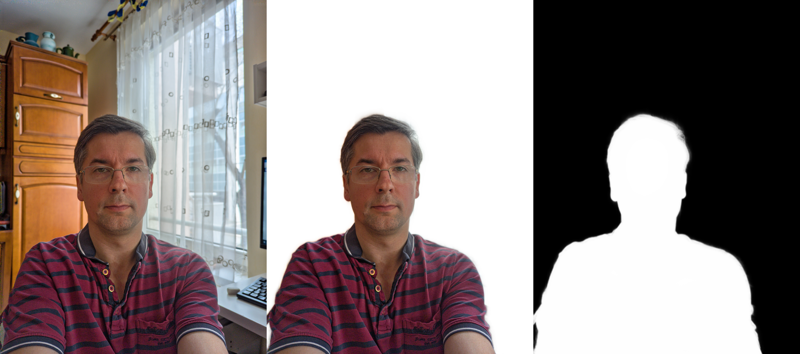

In [26]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined

# visualize all images

image = Image.open('image.jpg')
matte = Image.open('matte.png')
display(combined_display(image, matte))

## 5. Download image

Image with transparent background will be saved and downloaded. 

In [6]:
image.putalpha(matte)
image.save('transparent_img.png')

from google.colab import files
files.download('transparent_img.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Write image to: output.png


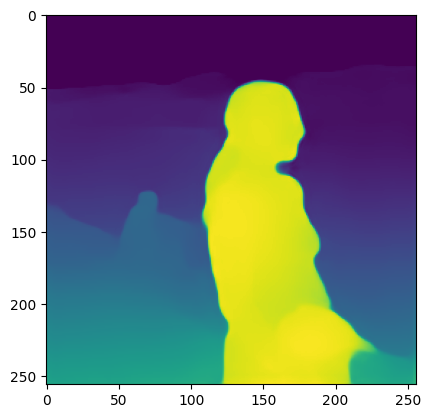

In [5]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

#url, filename = ("https://github.com/intel-isl/MiDaS/releases/download/v2/dog.jpg", "dog.jpg")
#urllib.request.urlretrieve(url, filename)

# the runtime initialization will not allocate all memory on the device to avoid out of GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_virtual_device_configuration(gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])

# input
img = cv2.imread('/content/MODNet/image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
#img = img[837:2700, 600:2000,:]
img = img[1237:2700, 600:2000,:]

img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
img_resized = tf.transpose(img_resized, [2, 0, 1])
img_input = img_resized.numpy()
reshape_img = img_input.reshape(1,3,256,256)
tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

# load model
#module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
output = module.signatures['serving_default'](tensor)
prediction = output['default'].numpy()
prediction = prediction.reshape(256, 256)

# output file
#prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(" Write image to: output.png")
depth_min = prediction.min()
depth_max = prediction.max()
img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")

cv2.imwrite("output.png", img_out)
plt.imshow(img_out)